In [48]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm.notebook import tqdm
import equinox as eqx
from jax.random import PRNGKey, split
from jax.tree_util import tree_map
from jax import numpy as jnp
from src.InferenceModel import InferenceModel, InferenceModelCfg
from src.utils.miscellaneous import dict_to_namedtuple
from src.utils.trace_dataset import load_traces
from pathlib import Path
from experiments.bayes3d.bayes3d import SceneSampler
from numpyro.handlers import trace, substitute

from src.gaussian_mixture_head import GaussianMixture, GaussianMixtureCfg
from src.real_nvp import RealNVP_Flow, RealNVPConfig

import bayes3d as j

from collections import OrderedDict
from jax import vmap, jit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:



variable_metadata = load_traces("tmp/1M_bayes3d_metadata.pkl")
variable_metadata = tree_map(lambda x: jnp.array(x, dtype=np.float32), variable_metadata)
variable_metadata = dict_to_namedtuple(variable_metadata)

# gmc = GaussianMixtureCfg(
#   resnet_mlp_width=512,
#   d_model=128,
#   resnet_mlp_depth=1,
#   num_mixtures=3,
# )

# continuous_distribution = GaussianMixture(c=gmc, key=PRNGKey(13))


continuous_distribution = RealNVP_Flow(
    c = RealNVPConfig(
      num_latents=1,
      num_blocks=8,
      num_layers_per_block=2,
      block_hidden_size=256,
      num_conds=256,
      normalizer_width=512,
      num_augments=91,
    ),
    key=PRNGKey(13),
  )


inference = InferenceModel(
  key=PRNGKey(0),
  c=InferenceModelCfg(
      variable_metadata=variable_metadata,
      d_model = 256,
      dropout_rate = 0.0,
      discrete_mlp_width = 512,
      discrete_mlp_depth=1,
      num_enc_layers=4,
      max_discrete_choices =6,
      num_input_variables = (1,225),
      num_observations =100,
    ),
  continuous_distribution=continuous_distribution
  )


In [54]:
inference = eqx.tree_deserialise_leaves("tmp/1M_bayes3d_gmm_best.eqx", inference)
inference = eqx.tree_inference(inference, True)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (160, 160, 512)


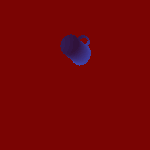

In [41]:
sampler = SceneSampler(
                        # mesh_paths=[Path("sample_objs/bunny.obj")],
                        mesh_paths=[Path("ycb_video_models/models/025_mug/textured_simple.obj")],
                        num_objects=1,
                        max_pose_xy_noise=0.3,
                        )
sampler_no_noise = lambda key: sampler(key, noise=False)
seed = PRNGKey(1234)
tr = trace(sampler_no_noise).get_trace(key=seed)
img, flattened_patches, obs = sampler_no_noise(key=seed)
gt_img = sampler.reconsctruct_from_patches(flattened_patches, (150,150), 15)
gt_img = j.viz.get_depth_image(gt_img)
gt_img

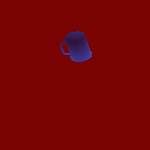

In [63]:
tr_ = OrderedDict({k: v['value'].dtype in (jnp.int32,) for k,v in tr.items()})
# fn = jit(lambda k: inference.rsample_static(obs, tr_, k))
# all_samples, _, all_log_p = vmap(fn)(split(PRNGKey(7), 2000))

idx = np.concatenate(all_log_p).reshape(-1).argsort()
best = idx[-3]
sampled_variables = tree_map(lambda x: x[best], all_samples)

model_pred = substitute(sampler_no_noise, sampled_variables)
img_, flattened_patches_, obs_ = model_pred(PRNGKey(5343))
pred_img = sampler.reconsctruct_from_patches(flattened_patches_, (150,150), 15)
pred_img = j.viz.get_depth_image(pred_img)
pred_img